In [1]:
import numpy as np
import os
from pytictoc import TicToc
import pandas as pd
import matplotlib.pyplot as plt
import gvar as gv
import scipy.interpolate
import scipy.optimize

In [2]:
def quadratic(x,a,b,c):
    return a*x**2+b*x+c

In [3]:
def spline(data): #fits t^3*E vs t with cubic spline
    xs = []
    ys = []
    ts =  data['t_flow'].unique()
    ts.sort()
    for t in ts:
        xs.append(t)
        cldata = list(data.loc[data['t_flow']==t]['t^2 E(t)']*(t))
        ys.append(gv.dataset.avg_data(cldata).mean)
    fit = scipy.interpolate.CubicSpline(xs,ys)
    return fit

In [ ]:
#Doesn't actually run locally, only here as the script for making the binary datasets on Alpine                                     
def load_data(betas):
    for beta in betas:
        rawdataW = []
        rawdataR = []
        del rawdataW
        del rawdataR
        #t.tic()                                                                                                                  
        flowpath = './f10l16t32b'+str(beta)+'m000_nHYP_pppa/flow/'
        flows = os.listdir(flowpath)
        R = 0
        W = 0
        for item in flows:
            if item[0] == 'C':
                filepath = open(flowpath+item)
                flowdata = np.delete(np.genfromtxt(filepath,delimiter=' '),0,1)
                delimpos = item.index('_')
                pref = item[:delimpos+1]
                config = item.replace(pref,'')
                config = int(config.replace('.log',''))
                flowdata=np.hstack((np.array([config]*np.shape(flowdata)[0])[:, np.newaxis], flowdata))
                flowdata=np.hstack((np.array([beta]*np.shape(flowdata)[0])[:, np.newaxis], flowdata))
                if item[3] == 0:
                    if W == 0:
                        rawdataW = flowdata
                        W = 1
                    else:
                        rawdataW = np.vstack((rawdataW,flowdata))

                elif item[3] == 8:
                    if R == 0:
                        rawdataR = flowdata
                        R = 1
                    else:
                        rawdataR = np.vstack((rawdataR,flowdata))
        nameW = "./data/f10l16t32b"+str(beta)+'m000_nHYP_pppa_Wilson/'
        nameR = "./data/f10l16t32b"+str(beta)+'m000_nHYP_pppa_Rectangle/'
        np.save(nameW, rawdataW)
        np.save(nameR, rawdataR)                                                                                                  
    return

In [ ]:
def conf_ave_data(data):
    betas = data['beta'].unique()
    for beta in betas:
        data_beta = data.loc[data['beta']==beta]
        ave_data_beta = data_beta.mean()
        if beta == betas[0]:
            ave_data = ave_data_beta
        else:
            ave_data=np.vstack((ave_data,ave_data_beta))
    return pd.DataFrame(ave_data,columns=cols)

In [4]:
cols = ['beta','config','t_flow','plaq','E_Cl','t^2 E(t)','d/dt t^2 E(t)','check','Q','t^2 E_ss','t^2 E_st','Re(Poly)_t','Im(Poly)_t','Re(Poly)_s','Im(Poly)_s']
def get_data(path,betas,end,L,T):

    
    for beta in betas:
        name = "/Users/nathanmackey/Desktop/"+path+str(beta)+end
        betadata = np.load(name)
        length = np.shape(betadata)[0]
        if beta == betas[0]:
                data = betadata
        else:
            data=np.vstack((data,betadata))
    dataset = pd.DataFrame(data,columns=cols)
    dataset['L'] = L
    dataset['T'] = T
    for beta in betas:
         if len(str(beta)) == 4:
              true_beta = beta*0.1
              dataset.loc[dataset['beta'] == beta, 'beta'] = true_beta
         elif len(str(beta)) == 5:
              true_beta = beta*0.01
              dataset.loc[dataset['beta'] == beta, 'beta'] = true_beta
     
    
    return dataset
    

In [14]:
L24t48W = get_data('nf10_data/24.24.24.48/f10l24t48b', [920,940,950,960,980,100,105,110,115,120], 'm000_nHYP_pppa_Wilson.npy',24,48)
L24t48R = get_data('nf10_data/24.24.24.48/f10l24t48b', [920,940,950,960,980,100,105,110,115,120], 'm000_nHYP_pppa_Rectangle.npy',24,48)
L28t56W = get_data('nf10_data/28.28.28.56/f10l28t56b', [120,115,110,105,100,980,960,940,920], 'm000_nHYP_pppa_Wilson.npy',28,56)
L28t56R = get_data('nf10_data/28.28.28.56/f10l28t56b', [120,115,110,105,100,980,960,940,920], 'm000_nHYP_pppa_Rectangle.npy',28,56)
L32t64W = get_data('nf10_data/32.32.32.64/f10l32t64b', [120,115,110,105,100,980,960,940], 'm000_nHYP_pppa_Wilson.npy',32,64)
L32t64R = get_data('nf10_data/32.32.32.64/f10l32t64b', [120,115,110,105,100,980,960,940], 'm000_nHYP_pppa_Rectangle.npy',32,64)
L36t72W = get_data('nf10_data/36.36.36.72/f10l36t72b', [120,115,110,105,100], 'm000_nHYP_pppa_Wilson.npy',36,72)
L36t72R = get_data('nf10_data/36.36.36.72/f10l36t72b', [120,115,110,105,100], 'm000_nHYP_pppa_Rectangle.npy',36,72)






In [15]:
mdataW=pd.concat([L24t48W,L28t56W,L32t64W,L36t72W])
mdataR=pd.concat([L24t48R,L28t56R,L32t64R,L36t72R])

In [7]:
def fivept(data,t):
    tfs = data['t_flow'].unique()
    ind= np.where(tfs == t)[0][0]
    dts = [tfs[ind-1]-tfs[ind-2],tfs[ind]-tfs[ind-1],tfs[ind+1]-tfs[ind],tfs[ind+2]-tfs[ind+1]]
    term1 = np.array(data.loc[data['t_flow']==tfs[ind-2]]['t^2 E(t)'])
    term2 = np.array(data.loc[data['t_flow']==tfs[ind-1]]['t^2 E(t)'])
    term3 = np.array(data.loc[data['t_flow']==tfs[ind+1]]['t^2 E(t)'])
    term4 = np.array(data.loc[data['t_flow']==tfs[ind+1]]['t^2 E(t)'])
    denom = 12*(tfs[ind]-tfs[ind-1])
    dg = (term1-8*term2+8*term3-term4)/(denom)
    return gv.dataset.avg_data(dg)

In [8]:
def therm(data,operator,betas,tf,name):
    for beta in betas:
        bdata =data.loc[data['beta']==beta]
        if operator == 'poly_mag':
            bdata =bdata.loc[data['t_flow']==tf]
            plt.scatter(bdata['config'],bdata['Im(Poly)_t']**2+bdata['Re(Poly)_t']**2,label = operator+ '  '+name +'_b' +str(beta))
            plt.ylabel('|Poly|')
        elif operator == 'beta(g2)':
            confs = bdata['config'].unique()
            confders = []
            for conf in confs:
                cdata = bdata.loc[bdata['config']==conf]
                cspline = scipy.interpolate.CubicSpline(cdata['t_flow'].to_list(),cdata['t^2 E(t)'].to_list())
                confders.append(-cspline(tf,1)*52*tf)
            plt.scatter(confs,confders,label= name + '_b' +str(beta))
        else:
            bdata =bdata.loc[data['t_flow']==tf]
            plt.scatter(bdata.loc[bdata['config']>105]['config'],bdata.loc[bdata['config']>105][operator]*52, label= name + '_b' +str(beta))
            avg = gv.dataset.avg_data(list(bdata[operator])).mean*52
            #plt.plot(bdata.loc[bdata['config']>105]['config'],[avg]*len(bdata.loc[bdata['config']>105]['config']),label=name + ' average',linewidth=3)
            plt.ylabel(operator+r"$\cdot 52$")
            plt.xlabel('config')

    plt.grid(True)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

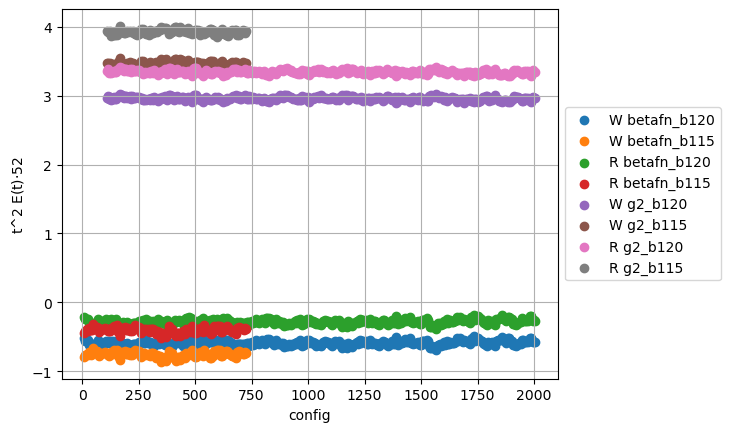

In [194]:
#therm(L28t56W,'t^2 E(t)',[120],2.0,'L28')
#therm(mdataW.loc[mdataW['L']==28],'t^2 E(t)',[120],2.0,'L28')
#therm(L32t64W,'t^2 E(t)',[120],2.0,'L32')
#therm(L36t72W,'t^2 E(t)',[120],2.0,'L36')
#therm(L32t64W,'t^2 E(t)',[115],2.0,'L32t64')
#print(L28t56W.loc[L28t56W['config']==305]['t_flow'].to_list())
#therm(L28t56W,'beta(g2)',[120],2.0,'Wilson')
therm(L28t56W,'beta(g2)',[120,115],2.0,'W betafn')
therm(L28t56R,'beta(g2)',[120,115],2.0,'R betafn')
therm(L28t56W,'t^2 E(t)',[120,115],2.0,'W g2')
therm(L28t56R,'t^2 E(t)',[120,115],2.0,'R g2')
#therm(L32t64W,'t^2 E(t)',[120],4.0,'L32t64')
#therm(L36t72W,'t^2 E(t)',[120],20.0,'L36t72')
#therm(L36t72W,'t^2 E(t)',[120],12.0,'L36t72')

In [ ]:
def betafng(data,betas,L,thermcut,tstart,tend,name):
    for beta in betas:
        beta_data = data.loc[data['beta']==beta].loc[data['config']>thermcut]
        t2Ecl = []
        errors = []
        tds = []
        dcl = []
        tfs = beta_data['t_flow'].unique()
        for i in range(0,len(tfs)-1):
            tds.append((tfs[i+1]+tfs[i])/2)
            cldataf = list(beta_data.loc[beta_data['t_flow']==tfs[i+1]]['t^2 E(t)'])
            cldatab = list(beta_data.loc[beta_data['t_flow']==tfs[i]]['t^2 E(t)'])
            cldata = list(-1*(tds[i]*(np.array(cldataf)-np.array(cldatab))/(tfs[i+1]-tfs[i])))
            dcl.append(gv.dataset.avg_data(cldata).mean)
            cldatag = beta_data.loc[beta_data['t_flow']==tfs[i]]['t^2 E(t)']*52
            cldatag = list(cldatag)
            t2Ecl.append(gv.dataset.avg_data(cldatag).mean)
            errors.append(gv.dataset.avg_data(cldatag).sdev) 
        plt.errorbar(t2Ecl,dcl,fmt='.',label = name+'b'+str(beta))
    plt.grid(True)
    plt.legend()
    #plt.xlim([0,0.04])
    plt.xlabel(r'$g^2$')
    plt.ylabel(r'$t \cdot \frac{d (g^2)}{d t}$')
    plt.title(r'$\beta (t)$ with L=36, Wilson Action')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    return

In [ ]:
betafng(L24t48W,[920],24,100,5,23,'')
#betafng(L36t72W,[115,120],36,100,5,23,'')

In [ ]:
def t1plot(data,betas,L,thermcut,name):

    for beta in betas:
        beta_data = data.loc[data['beta']==beta].loc[data['config']>thermcut]
        t2Ecl = []
        errors = []
        tfs = beta_data['t_flow'].unique()
        for i in range(0,len(tfs)):
            cldata = beta_data.loc[beta_data['t_flow']==tfs[i]]['t^2 E(t)']*52
            cldata = list(cldata)
            t2Ecl.append(gv.dataset.avg_data(cldata).mean)
            errors.append(gv.dataset.avg_data(cldata).sdev)
        plt.errorbar((tfs),t2Ecl,yerr=errors,fmt='.',label = name+'L'+str(L)+'B'+str(beta))
    plt.grid(True)
    plt.legend()
    #plt.xlim([0,4.0])
    plt.xlabel(r'$t_f$')
    plt.ylabel(r'$t_f^2 \: E_{Cl} \: \cdot N$')
    plt.title(r'$g^2$ with L=24, Wilson Action')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    return

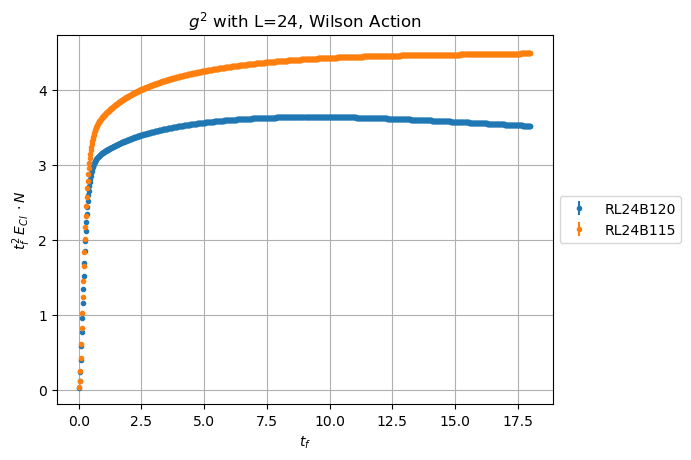

In [196]:
#t1plot(L16t32W,[120],16,100,0,23,'')
#t1plot(L24t48W,[120,115],24,100,'W')
t1plot(L24t48R,[120,115],24,100,'R')


In [238]:
def infvol(beta,Ls,thermcut,t,act):
    xs = []
    ys = []
    yerrs = []
    for L in Ls:
        if act == 'W':
            dataL = mdataW.loc[mdataW['L']==L]
            dataL = dataL.loc[dataL['beta']==beta]
            dataL = dataL.loc[dataL['config']>thermcut]
            dataL = dataL.loc[dataL['t_flow']==t]
        else:
            dataL = mdataR
        xs.append(L**(-4))
        ys.append(gv.dataset.avg_data(list(dataL['t^2 E(t)']*52)).mean)
        yerrs.append(gv.dataset.avg_data(list(dataL['t^2 E(t)']*52)).sdev)
    plt.errorbar(xs,ys,yerr=yerrs,fmt='.',label = r'$t_f =$ '+str(t))        
    plt.grid(True)
    plt.ylabel(r'$g^2$')
    plt.xlabel(r'$1/L^4$')
    plt.title(r' $\beta_b$ = '+str(beta/10))
    plt.legend()
    #plt.legend()
    #plt.ylim([3.1,3.8])
    return

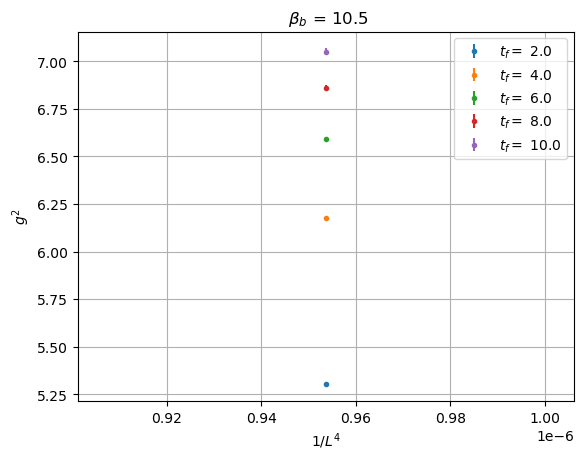

In [239]:
beta = 105
Ls = [32]
ts = [2.0,4.0,6.0,8.0,10.0]
configcut = 200
for t in ts:
    infvol(beta,Ls,configcut,t,'W')

In [ ]:
ts = [2.0,3.0,4.0]
beta_b = 100
for t in ts:
    Ls = [1/24**4,1/28**4,1/32**4,1/36**4]
    dgs = [fivept(L24t48W.loc[L24t48W['beta']==beta_b],t).mean,fivept(L28t56W.loc[L28t56W['beta']==beta_b],t).mean,fivept(L32t64W.loc[L32t64W['beta']==beta_b],t).mean,fivept(L36t72W.loc[L36t72W['beta']==beta_b],t).mean]
    dgserrs = [fivept(L24t48W.loc[L24t48W['beta']==beta_b],t).sdev,fivept(L28t56W.loc[L28t56W['beta']==beta_b],t).sdev,fivept(L32t64W.loc[L32t64W['beta']==beta_b],t).sdev,fivept(L36t72W.loc[L36t72W['beta']==beta_b],t).sdev]
    plt.errorbar(Ls,-t*np.array(dgs),yerr=t*np.array(dgserrs),fmt='.',label = r'$t_f =$ '+str(t))
plt.grid(True)
plt.ylabel(r'$\beta_{GF}(g^2)$')
plt.xlabel(r'$1/L^4$')
plt.title(r' $\beta_b$ = '+str(beta_b/10))
#plt.ylim([0,0.025])
plt.legend()

In [11]:
def bvg2atT(data,tf,betas,Ls,thermcut,color,Act):
    infpts = []
    for L in Ls:
        dataL=data.loc[data['L']==L]
        dataL=dataL.loc[dataL['config']>thermcut]
        bs=[]
        berrs=[]
        gs= []
        gerrs = []
        Lpt = []
        for beta in betas:
            try:
                dataB=dataL.loc[dataL['beta']==beta]
                cs = spline(dataB)
                betafn = 52*(cs(tf)/tf-cs(tf,1))
                g2 = gv.dataset.avg_data(list(dataB.loc[dataB['t_flow']==tf]['t^2 E(t)']))*52
                y = betafn/(g2**2)
                bs.append(y.mean)
                berrs.append(y.sdev)
                gs.append(g2.mean)
                gerrs.append(g2.sdev)
            except:
                continue
        plt.errorbar(gs,bs,xerr=gerrs,yerr=berrs,fmt='.',label=str(L)+' '+Act)
        fitopt, fitcov = scipy.optimize.curve_fit(quadratic,gs,bs)
        pltrange = np.linspace(min(gs),17,100)
        plt.plot(pltrange,quadratic(np.array(pltrange),fitopt[0],fitopt[1],fitopt[2]),label=str(L)+' '+Act+' fit',ls='--')
        infrange = np.linspace(min(gs),17,100)
        Lpt = quadratic(np.array(infrange),fitopt[0],fitopt[1],fitopt[2])
        if L == Ls[0]:
            Lpts = Lpt
        else:
            Lpts=np.array(np.vstack([np.array(Lpts),np.array(Lpt)]))
            cols = int(Lpts.shape[1])
    for jj in range(0,cols):
        pts = list(Lpts[:,jj])
        xs = 1/np.array(Ls)
        fit = np.polyfit(xs,pts,1)
        infpts.append(fit[1])
    plt.plot(infrange,infpts,label=r'L = $\infty$')
    plt.grid(True)
    plt.ylabel(r'$\beta (g^2) / g^4$')
    plt.xlabel(r'$g^2$')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(r'$t_f =$' +str(tf))
    #plt.ylim([-0.045,0])

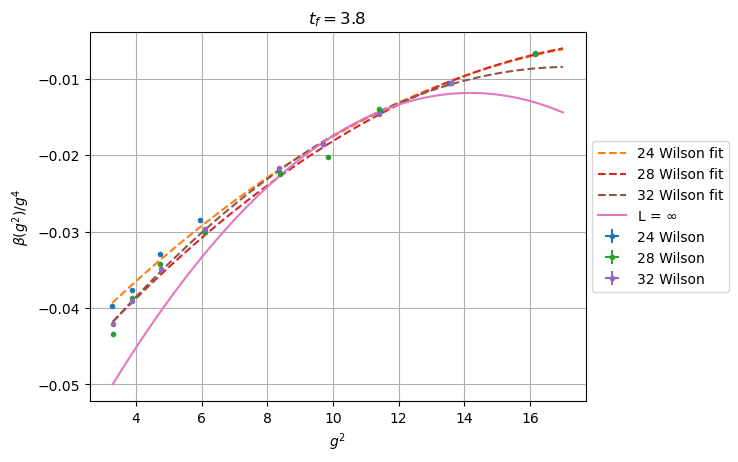

In [16]:

bvg2atT(mdataW,3.8,[120,115,110,105,100,980,960,940,920],[24,28,32],0,'tab:purple','Wilson')
#bvg2atT(mdataW,3.8,[120,115,110,105,100,980,960,940,920],[28],0,'tab:blue','Wilson')
#bvg2atT(mdataW,3.8,[120,115,110,105,100,980,960],[32],0,'tab:red','Wilson')
#bvg2atT(mdataW,3.8,[120,115,110,105],[36],0,'tab:green','Wilson')

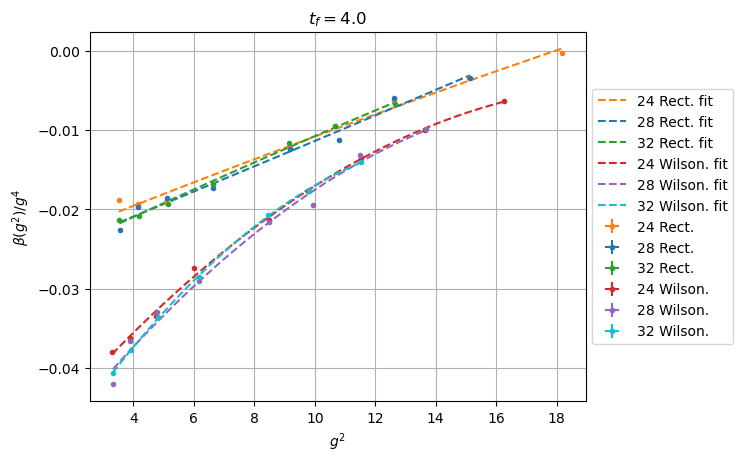

In [200]:
bvg2atT(mdataR,4.0,[120,115,110,105,100,980,960,940,920],[24],0,'tab:orange','Rect.')
bvg2atT(mdataR,4.0,[120,115,110,105,100,980,960,940],[28],0,'tab:blue','Rect.')
bvg2atT(mdataR,4.0,[120,115,110,105,100,980,960],[32],0,'tab:green','Rect.')
bvg2atT(mdataW,4.0,[120,115,110,105,100,980,960,940,920],[24],0,'tab:red','Wilson.')
bvg2atT(mdataW,4.0,[120,115,110,105,100,980,960,940],[28],0,'tab:purple','Wilson.')
bvg2atT(mdataW,4.0,[120,115,110,105,100,980,960],[32],0,'tab:cyan','Wilson.')

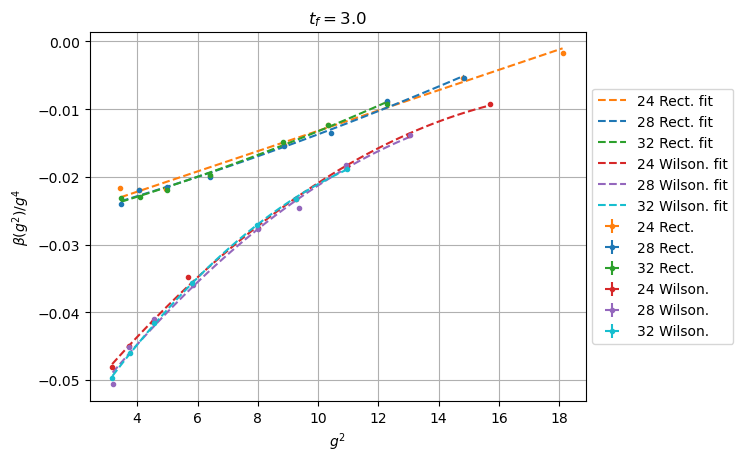

In [202]:
bvg2atT(mdataR,3.0,[120,115,110,105,100,980,960,940,920],[24],0,'tab:orange','Rect.')
bvg2atT(mdataR,3.0,[120,115,110,105,100,980,960,940],[28],0,'tab:blue','Rect.')
bvg2atT(mdataR,3.0,[120,115,110,105,100,980,960],[32],0,'tab:green','Rect.')
bvg2atT(mdataW,3.0,[120,115,110,105,100,980,960,940,920],[24],0,'tab:red','Wilson.')
bvg2atT(mdataW,3.0,[120,115,110,105,100,980,960,940],[28],0,'tab:purple','Wilson.')
bvg2atT(mdataW,3.0,[120,115,110,105,100,980,960],[32],0,'tab:cyan','Wilson.')

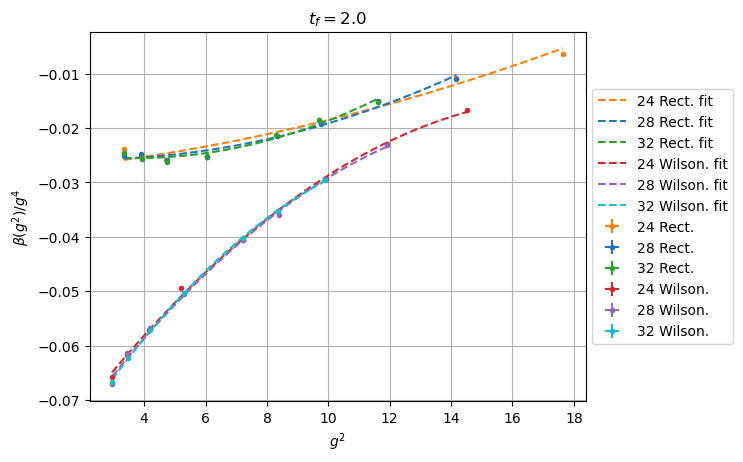

In [203]:
bvg2atT(mdataR,2.0,[120,115,110,105,100,980,960,940,920],[24],0,'tab:orange','Rect.')
bvg2atT(mdataR,2.0,[120,115,110,105,100,980,960,940],[28],0,'tab:blue','Rect.')
bvg2atT(mdataR,2.0,[120,115,110,105,100,980,960],[32],0,'tab:green','Rect.')
bvg2atT(mdataW,2.0,[120,115,110,105,100,980,960,940,920],[24],0,'tab:red','Wilson.')
bvg2atT(mdataW,2.0,[120,115,110,105,100,980,960,940],[28],0,'tab:purple','Wilson.')
bvg2atT(mdataW,2.0,[120,115,110,105,100,980,960],[32],0,'tab:cyan','Wilson.')

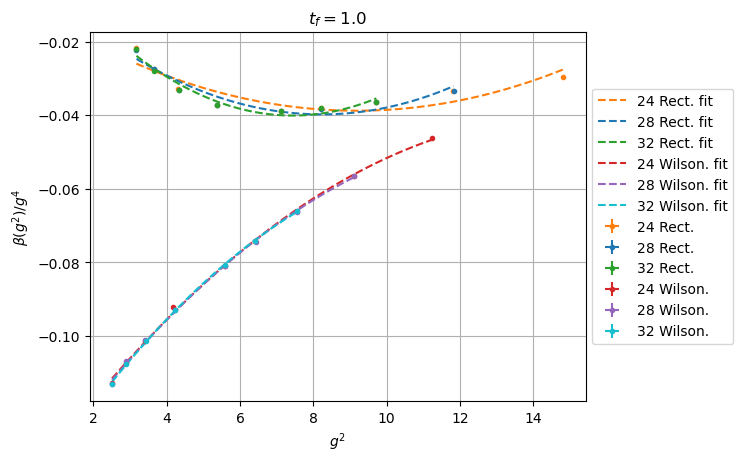

In [201]:
bvg2atT(mdataR,1.0,[120,115,110,105,100,980,960,940,920],[24],0,'tab:orange','Rect.')
bvg2atT(mdataR,1.0,[120,115,110,105,100,980,960,940],[28],0,'tab:blue','Rect.')
bvg2atT(mdataR,1.0,[120,115,110,105,100,980,960],[32],0,'tab:green','Rect.')
bvg2atT(mdataW,1.0,[120,115,110,105,100,980,960,940,920],[24],0,'tab:red','Wilson.')
bvg2atT(mdataW,1.0,[120,115,110,105,100,980,960,940],[28],0,'tab:purple','Wilson.')
bvg2atT(mdataW,1.0,[120,115,110,105,100,980,960],[32],0,'tab:cyan','Wilson.')

In [32]:
def bvg2two(data,tf,betas,Ls,thermcut,color,Act):
    for L in Ls:
        dataL=data.loc[data['L']==L]
        dataL=dataL.loc[dataL['config']>thermcut]
        bs=[]
        berrs=[]
        gs= []
        gerrs = []
        for beta in betas:
            dataB=dataL.loc[dataL['beta']==beta]
            cs = spline(dataB)
            betafn = 52*(cs(tf)/tf-cs(tf,1))
            g2 = gv.dataset.avg_data(list(dataB.loc[dataB['t_flow']==tf]['t^2 E(t)']))*52
            y = betafn
            bs.append(y)
            gs.append(g2.mean)
            gerrs.append(g2.sdev)
        plt.errorbar(gs,bs,xerr=gerrs,fmt='.',label=str(L)+' '+Act,c=color)
        fitopt, fitcov = scipy.optimize.curve_fit(quadratic,gs,bs)
        range = np.linspace(min(gs),max(gs),100)
        #plt.plot(range,quadratic(np.array(range),fitopt[0],fitopt[1],fitopt[2]),label=str(L)+' '+Act+' fit',c=color,ls='')         
    plt.grid(True)
    plt.ylabel(r'$\beta (g^2)$')
    plt.xlabel(r'$g^2$')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(r'$t_f =$' +str(tf)+' '+Act)
    plt.ylim([-3,2])

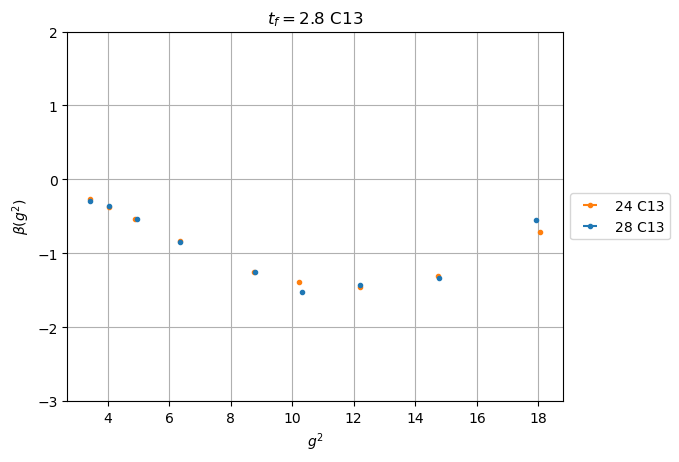

In [33]:
bvg2two(mdataR,2.8,[120,115,110,105,100,980,960,940,920],[24],0,'tab:orange','C13')
bvg2two(mdataR,2.8,[120,115,110,105,100,980,960,940,920],[28],0,'tab:blue','C13')



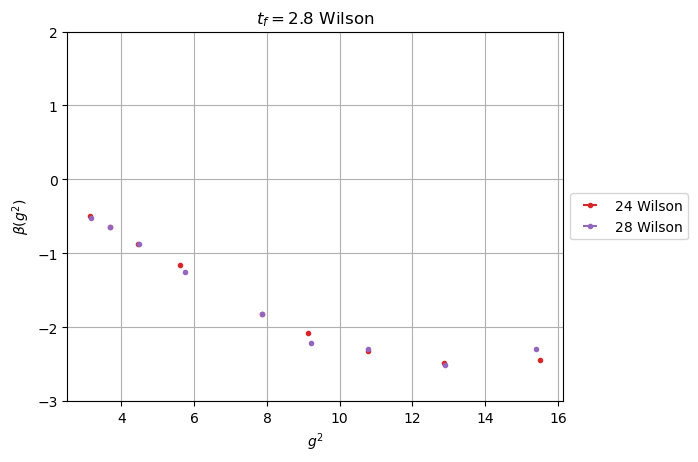

In [34]:
bvg2two(mdataW,2.8,[120,115,110,105,100,980,960,940,920],[24],0,'tab:red','Wilson')
bvg2two(mdataW,2.8,[120,115,110,105,100,980,960,940,920],[28],0,'tab:purple','Wilson')

In [10]:
def getfit(data,tf):
    betas = data['beta'].unique()
    bs = []
    gs = []
    for beta in betas:
        dataB=data.loc[data['beta']==beta]
        cs = spline(dataB)
        betafn = 52*(cs(tf)/tf-cs(tf,1))
        g2 = gv.dataset.avg_data(list(dataB.loc[dataB['t_flow']==tf]['t^2 E(t)']))*52
        y = betafn/(g2**2)
        bs.append(y.mean)
        gs.append(g2.mean)
    fitopt, fitcov = scipy.optimize.curve_fit(quadratic,gs,bs)
    return(fitopt)

In [18]:
def infvolex(data,Ls,ts,g2,name):
    xs = list(1/np.array(ts))
    dls = []
    dbs = []
    pts = []
    xls = list(1/np.array(Ls))
    for t in ts:
        c1s = []
        c2s = []
        c3s = []
        Lpts = []
        for L in Ls: #get fits for every L
            params = list(getfit(data.loc[data['L']==L],t))
            Lpts.append(quadratic(g2,params[0],params[1],params[2])*g2**2)
        Lfit = np.polyfit(xls,Lpts,1)
        pts.append(Lfit[1])
    fit = np.polyfit(xs,pts,1)
    fitr=np.array([0,0.6])
    plt.plot(fitr,fitr*fit[0]+fit[1])
    plt.scatter(xs,pts,label=name)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.title(r'$g^2=$'+str(g2))
    plt.xlabel(r'$a^2 / t$')
    plt.ylabel(r'$\beta(g^2)$')

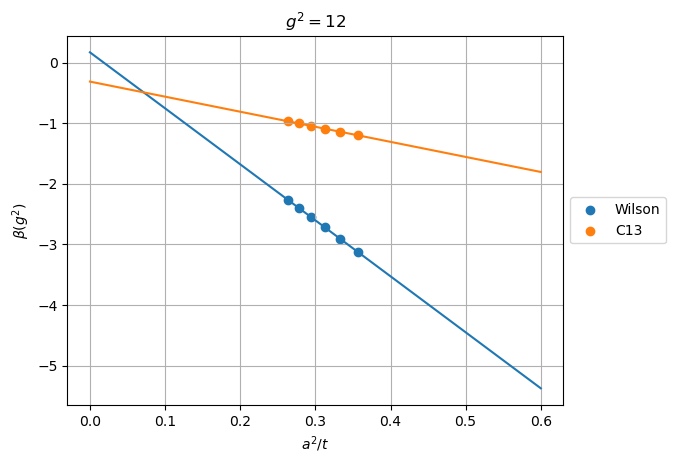

In [28]:
infvolex(mdataW,[24,28,32],[3.8,3.6,3.4,3.2,3.0,2.8],12,'Wilson')
infvolex(mdataR,[24,28,32],[3.8,3.6,3.4,3.2,3.0,2.8],12,'C13')
            


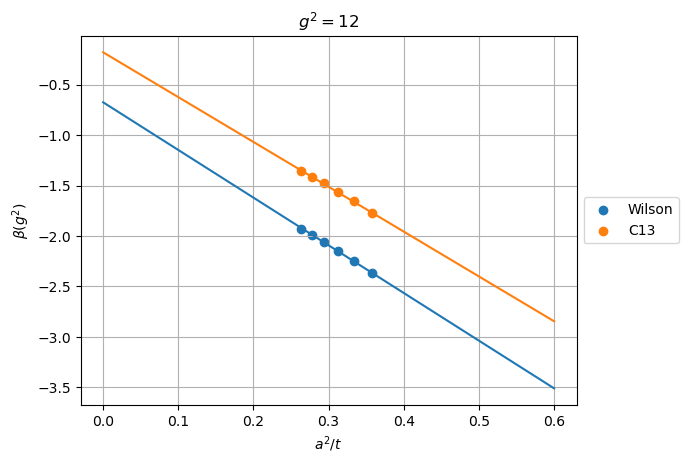

In [35]:
infvolex(mdataW,[24,28],[3.8,3.6,3.4,3.2,3.0,2.8],12,'Wilson')
infvolex(mdataR,[24,28],[3.8,3.6,3.4,3.2,3.0,2.8],12,'C13')